In [4]:
%pip install git+https://github.com/gbdrt/mu-ppl

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/gbdrt/mu-ppl to /tmp/pip-req-build-9wqzu9bt
  Running command git clone --filter=blob:none --quiet https://github.com/gbdrt/mu-ppl /tmp/pip-req-build-9wqzu9bt
  Resolved https://github.com/gbdrt/mu-ppl to commit bd6b483575e70ce40e84fc591ba2a9dc7d85dafd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [5]:
from mu_ppl import *

# [École Jeunes Chercheurs et Jeunes Chercheuses du GDRIFM](https://ejcim2024.sciencesconf.org/)

## An introduction to probabilistic programming with mu-PPL - Part 1


Probabilistic programs represent random variables.

In [6]:
def dice() -> int:
    a = sample(RandInt(1, 6), name="a")
    b = sample(RandInt(1, 6), name="b")
    return a + b

We can run the experiment representing the random variable.

In [7]:
dice()

10

The law of the random variable can be computed by an inference algorithm. 

For instance the enumeration algorithm for discrete distributions.

In [8]:
with Enumeration():
    dist: Categorical[int] = infer(dice)

We can get a sample of the distribution.


In [9]:
sample(dist)

3

We can compute the statistics of the distribution  and vizualize its mass function.

mean:  7.0 
standard deviation:  2.4494897427831783


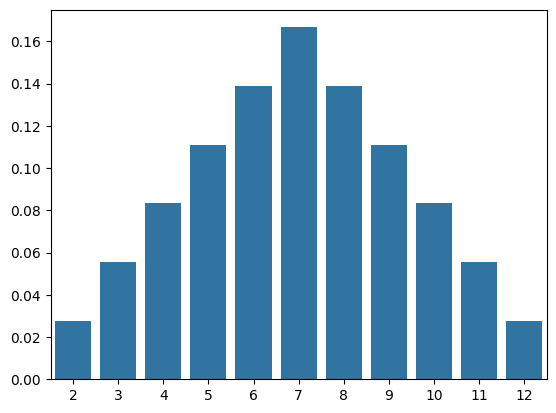

In [10]:

s = dist.stats()
print("mean: ",s[0], "\nstandard deviation: ", s[1])
viz(dist)


Conditioning can be hard: `assume(a!=b)` reject all samples that do not satisfy the property `a!=b`

(7.0, 2.1971768720102056)


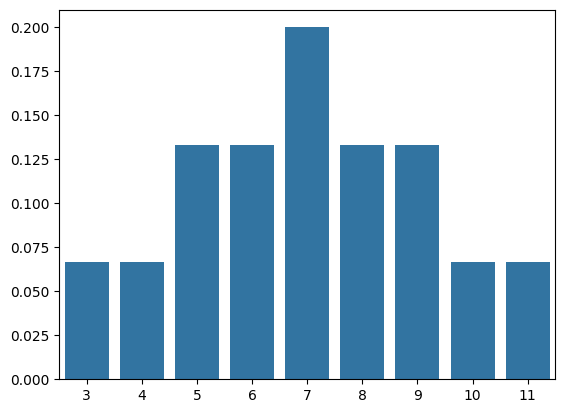

In [11]:
def hard_dice() -> int:
    a = sample(RandInt(1, 6), name="a")
    b = sample(RandInt(1, 6), name="b")
    assume (a != b)
    return a + b

with Enumeration():
    dist: Categorical[int] = infer(hard_dice)
    print(dist.stats())
    viz(dist)

100%|██████████| 10000/10000 [00:00<00:00, 128370.99it/s]


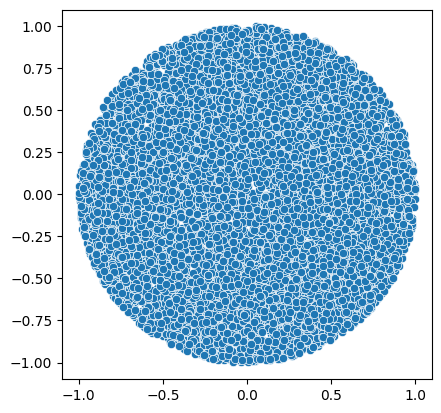

In [12]:
from typing import Tuple
import seaborn as sns 
import matplotlib.pyplot as plt

def disk() -> Tuple[float, float]:
    x = sample(Uniform(-1, 1))
    y = sample(Uniform(-1, 1))
    d2 = x**2 + y**2
    assume (d2 < 1)
    return (x, y)

with RejectionSampling(num_samples=10000):
    dist: Empirical = infer(disk)
    x, y = zip(*dist.samples)
    sns.scatterplot(x=x, y=y)
    plt.axis("scaled")
    plt.show()


Conditioning can be soft: `observe(Gaussian(d2, 0.1), o)` condition the law given observations.

100%|██████████| 10000/10000 [00:00<00:00, 14927.96it/s]


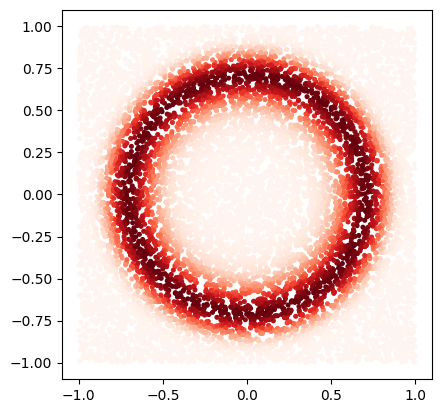

In [13]:
def position(o: float) -> Tuple[float, float]:
    x = sample(Uniform(-1, 1))
    y = sample(Uniform(-1, 1))
    d2 = x**2 + y**2
    observe(Gaussian(d2, 0.1), o)
    return (x, y)

with ImportanceSampling(num_particles=10000):
    dist: Categorical = infer(position, 0.5)
    w = dist.probs
    x, y = list(zip(*dist.values))
    plt.scatter(x, y, c=w**0.5, cmap='Reds', s=7)
    plt.axis("scaled")
    plt.show()


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 12564.50it/s]


(16.731493237809822, 1.930142338782812)


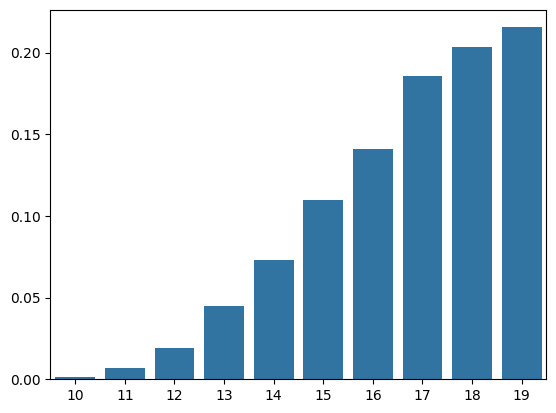

In [14]:

def success(s:int) -> int:
    n = sample(RandInt(10, 20))
    observe(Binomial(n, 0.5), s)
    return n

with ImportanceSampling(num_particles=10000):
    dist: Categorical = infer(success, 10)
    print(dist.stats())
    viz(dist)
    plt.show()

### Exercises

**Question 1**

Define a probabilistic program that models the number of tosses of a fair coin before getting a Tail.

**Question 2**

Use hard conditioning to define a probabilistic program that models a fair coin using two tosses of a bias coin. 

**Question 3** 

Describe the random variable that is modeled by this program.

100%|██████████| 10000/10000 [00:06<00:00, 1601.35it/s]


(0.25014684088884864, 0.12030089357674102)


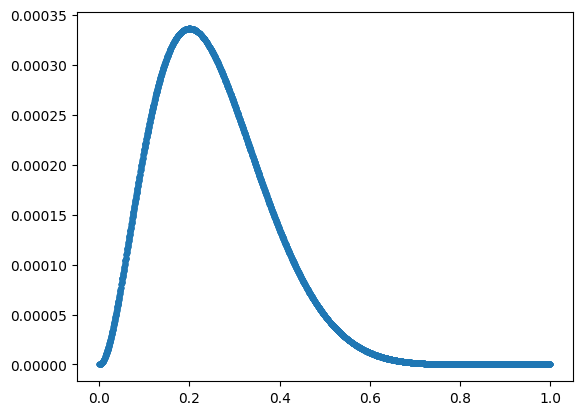

In [15]:
def coin(obs: list[int]) -> float:
    p = sample(Uniform(0, 1))
    for o in obs:
        observe(Bernoulli(p), o)
    return p 

with ImportanceSampling(num_particles=10000):
    dist: Categorical = infer(coin, [0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
    print(dist.stats())
    viz(dist)

**Question 4**

In 1886, Francis Galton measures the rate of regression in hereditary stature.

He used a frequency table *Number of Adult Children of various Statures born of 205 Mid-Parents of various Statures*.

He divided the data into subgroups according to the average height of the two parents. He computed the median of children stature against the median mid-parent stature and recognized a straight line.

*Galton (1886) “Regression Towards Mediocrity in Hereditary Stature,” Journal
of the Anthropological Institute of Great Britain and Ireland, 15, 246–263.*

Use the following data to reproduce Galton result.

In [18]:
import pandas as pd
import numpy as np

raw = pd.read_csv("galton.csv")
data = raw.loc[:,["parent","child"]]

data

,parent,child
0,70.5,61.7
1,68.5,61.7
2,65.5,61.7
3,64.5,61.7
4,64.0,61.7
...,...,...
923,69.5,73.7
924,69.5,73.7
925,69.5,73.7
926,69.5,73.7


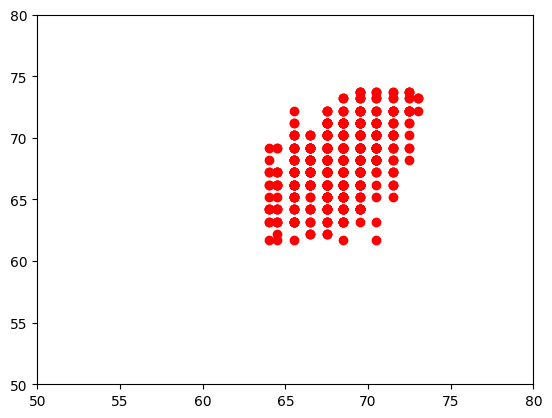

In [19]:
x_obs = data["parent"]
y_obs =  data["child"]

ax=plt.axes()
ax.set_xlim(50, 80)
ax.set_ylim(50,80)
plt.scatter(x_obs, y_obs, color='red', zorder=1)

In [20]:
from typing import Tuple

def model(data):
    # modify the following model to fit the data
    a = sample(Dirac(1), name="a")
    b = sample(Dirac(1), name="b")
    return (a, b)

with ImportanceSampling(num_particles=1000):
    dist: Categorical[Tuple[float,float]] = infer(model, data)


100%|██████████| 1000/1000 [00:00<00:00, 588178.94it/s]


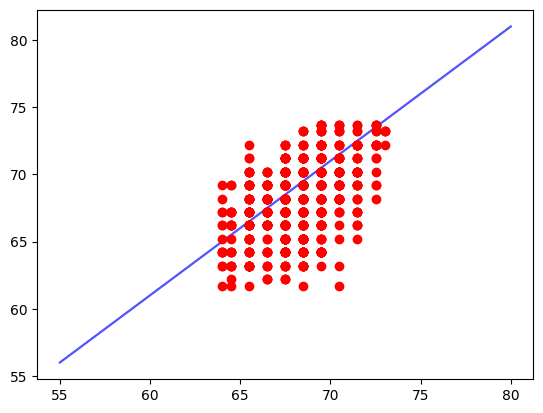

In [21]:
for i in range(10):
    x = np.linspace(55, 80, 2)
    a, b = dist.sample()
    plt.plot(x, a * x + b, color='blue', alpha=0.1, zorder=0)

plt.scatter(x_obs, y_obs, color='red', zorder=1)

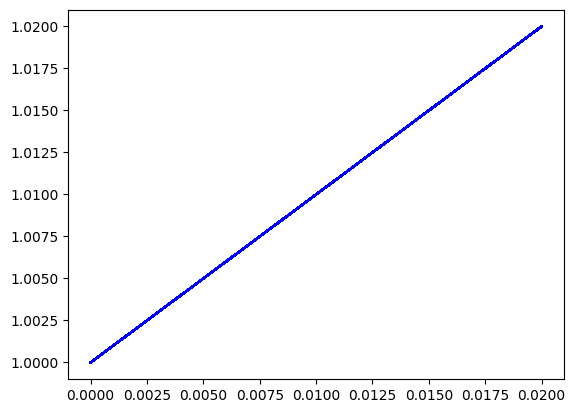

In [22]:
for i in range(1000):
    x = np.linspace(0, 0.02, 2)
    a, b = dist.sample()
    plt.plot(x, a * x + b, color='blue', alpha=0.1, zorder=0)

### Hierarchical Models

 In his book *Théorie analytique des probabilités, 1812*, Laplace compute the probability that the proportion of boys and girls registered in birth records is bigger in London than in Paris given historical data.


In [23]:
def laplace(f1: int, g1: int, f2: int, g2: int) -> float:
    p = sample(Uniform(0, 1), name="p")
    q = sample(Uniform(0, 1), name="q")
    observe(Binomial(f1 + g1, p), g1)
    observe(Binomial(f2 + g2, q), g2)
    return q > p

# Paris    1745 - 1784
fp = 377555
gp = 393386
# Londres  1664 - 1758
fl = 698958
gl = 737629

with ImportanceSampling(num_particles=100000):
    dist: Categorical = infer(laplace, fp, gp, fl, gl)

s = dist.stats()    
print("q>p with probability ", s[0],"\nStandard deviation: ",s[1])


100%|██████████| 100000/100000 [00:13<00:00, 7589.19it/s]


q>p with probability  0.9991545504836002 
Standard deviation:  0.08481959998972251


 In his book *Théorie analytique des probabilités, 1812*, Laplace compute the probability that the proportion of boys and girls registered in birth records is bigger in London than in Paris given historical data.


### Sémantique

Calculer la sémantique des programmes suivants:

100%|██████████| 1000/1000 [00:00<00:00, 107197.18it/s]


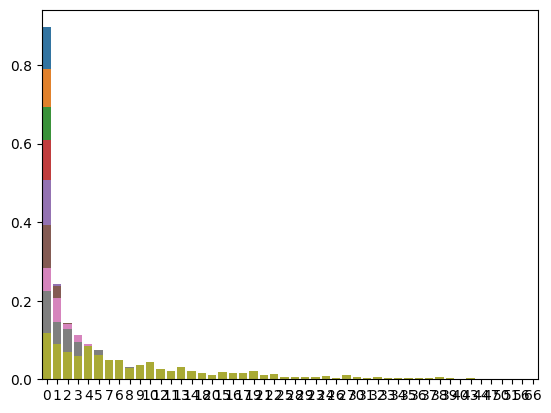

In [24]:
def stop(p:float):
    n = 0
    while sample(Bernoulli(p)):
        n = n+1
    return n

with ImportanceSampling(num_particles=1000):
    for i in range(1,10):
        dist = infer(stop, i/10)
        viz(dist)


In [25]:
def flip(p):
    x = sample(Bernoulli(p), name='x')
    y = sample(Bernoulli(p), name='y')
    assume(x!=y)
    return x

with Enumeration():
    for i in range(1, 10):
        dist: Categorical = infer(flip, i/10)
        print("bias: ", i/10," mean: ", dist.stats()[0])


bias:  0.1  mean:  0.5
bias:  0.2  mean:  0.5
bias:  0.3  mean:  0.5
bias:  0.4  mean:  0.5
bias:  0.5  mean:  0.5
bias:  0.6  mean:  0.5
bias:  0.7  mean:  0.5
bias:  0.8  mean:  0.5
bias:  0.9  mean:  0.5


100%|██████████| 10000/10000 [00:05<00:00, 1695.27it/s]


(0.2513123090921254, 0.11963088849957532)


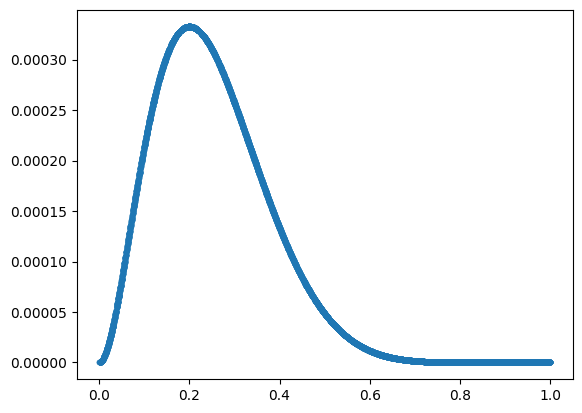

In [26]:
def coin(obs: list[int]) -> float:
    p = sample(Uniform(0, 1))
    for o in obs:
        observe(Bernoulli(p), o)
    return p

with ImportanceSampling(num_particles=10000):
    dist: Categorical = infer(coin, [0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
    print(dist.stats())
    viz(dist)


In [27]:
def flip_rec(p, s=' '):
    x = sample(Bernoulli(p), name='x')
    y = sample(Bernoulli(p), name='y')
    if (x!=y):
        return x
    else:
        return flip_rec(p, s+'_')

with ImportanceSampling(num_particles=1000):
    for i in range(1, 10):
        dist: Categorical = infer(flip_rec, i/10)
        print("bias: ", i/10," mean: ", dist.stats()[0])


100%|██████████| 1000/1000 [00:00<00:00, 75619.37it/s]


bias:  0.1  mean:  0.5149999999999999


100%|██████████| 1000/1000 [00:00<00:00, 139684.42it/s]


bias:  0.2  mean:  0.49899999999999994


100%|██████████| 1000/1000 [00:00<00:00, 177469.07it/s]


bias:  0.3  mean:  0.49799999999999994


100%|██████████| 1000/1000 [00:00<00:00, 217795.41it/s]


bias:  0.4  mean:  0.4879999999999999


100%|██████████| 1000/1000 [00:00<00:00, 202369.20it/s]


bias:  0.5  mean:  0.49899999999999994


100%|██████████| 1000/1000 [00:00<00:00, 186372.10it/s]


bias:  0.6  mean:  0.4809999999999999


100%|██████████| 1000/1000 [00:00<00:00, 168020.83it/s]


bias:  0.7  mean:  0.4909999999999999


100%|██████████| 1000/1000 [00:00<00:00, 101297.01it/s]


bias:  0.8  mean:  0.47499999999999987


100%|██████████| 1000/1000 [00:00<00:00, 84266.97it/s]

bias:  0.9  mean:  0.514
